# Install Transformers Library

In [1]:
# !pip install transformers
# !pip install --upgrade transformers
# from transformers import __version__; print(__version__)

In [3]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset

In [52]:
data = pd.read_csv('ML-TextClassification\02 - Email Classification - EnronData\dataset\preprocessed.csv')
data.head()

,X-Folder,text
0,california,caiso notice summer 2001 generation rfb market...
1,california,ca iso cal px information related 2000 market ...
2,california,caiso notification update inter sc trades adju...
3,california,update mif meeting presentations iso website u...
4,california,mif presentations presentations market issues ...


In [19]:
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
print(data.isnull().sum())

(16911, 2)
(16911, 2)
X-Folder    0
text        0
dtype: int64


In [37]:

# print unique values in the column
data['X-Folder'].unique()
# print unique values in the column and their counts in descending order
data['X-Folder'].value_counts()
# print total number of unique values in the column
data['X-Folder'].nunique()

30

In [24]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

# call label_encoder on the data
y = label_encoder(data)
x = data['text']


# Split train dataset into train, validation and test sets

In [25]:
train_text, temp_text, train_labels, temp_labels = train_test_split(x, y, 
                                                                    random_state=2018, 
                                                                    test_size=0.7, 
                                                                    stratify=y)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [26]:
train_text

7228     california update 7 16 01 executive summary so...
4468     eol credit responses 09 13 00 tana following c...
10293    pogo c lea co keep mind wait see well producer...
8543     fw original message kitchen louise sent tuesda...
6217     lsu visit resume datren forwarding resume anal...
                               ...                        
5250     revision 1st request approve attached request ...
13816            apb checkout 513386 apb 514418 broker cob
6044     interview schedule rabi de attached please fin...
3827     exhibit 1 feb 00 chris spreadsheet sent yester...
14331    5 1 checkout bloomberg chris mallory deal 5981...
Name: text, Length: 5073, dtype: object

In [27]:
test_text

7611     fw original message oquinn kari sent friday de...
10606    updated livelink discussion hello everyone con...
10989    cal 2000 historical enronearthsmartbizmix disc...
15634    clickpaper report 12 20 00 1 2 01 questions re...
13098    presentations jim two presentations old presen...
                               ...                        
551      power plants great river power tex information...
16804    bally total fitness offer wtc tenants us world...
1010     project finance week march 11 15 new york city...
12163    charles la bella follow yesterday e mail attac...
11351    revised cinergy model gents made following cha...
Name: text, Length: 5919, dtype: object

In [28]:
print(type(test_text))
print(type(test_labels))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


# Import BERT Model and BERT Tokenizer

In [29]:
# import multilingual BERT base pretrained model
# bert = AutoModel.from_pretrained('bert-base-multilingual-cased')
# tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

bert_base_uncased = AutoModel.from_pretrained('bert-base-uncased')
# Load the multilingual BERT tokenizer
tokenizer_base_uncased = AutoTokenizer.from_pretrained('bert-base-uncased')


In [29]:
# encode the texts

encoded_dict = tokenizer_base_uncased.batch_encode_plus(sample_text, 
                                            add_special_tokens=True, 
                                            padding=True, 
                                            truncation=True, 
                                            max_length=10, 
                                            return_attention_mask=True, 
                                            return_tensors='pt')
# print the encoded output
print(encoded_dict)

{'input_ids': tensor([[  101,  1045,  2467,  2203,  2039,  2746,  2067,  2000,  2023,   102],
        [  101,  2057,  2097,  2986,  1011,  8694,  1037, 14324,  2944,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


# Tokenization

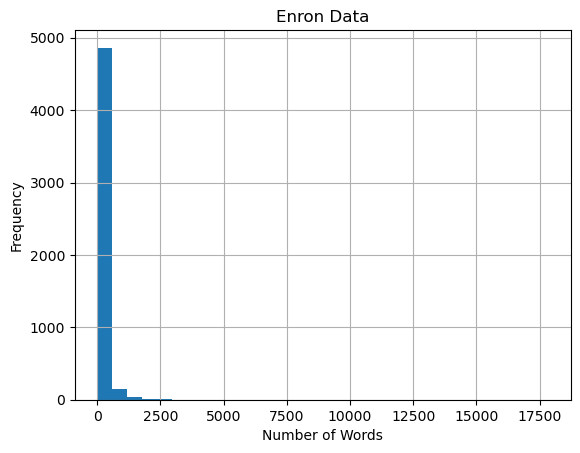

In [32]:
import matplotlib.pyplot as plt
seq_len = []
for text in train_text:
    if isinstance(text, str):
        seq_len.append(len(text.split()))
pd.Series(seq_len).hist(bins=30)
# add title and labels
plt.title('Enron Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [33]:
max_seq_len = 500
# tokenize and encode sequences in the training set
tokens_train = tokenizer_base_uncased.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# tokenize and encode sequences in the validation set
tokens_val = tokenizer_base_uncased.batch_encode_plus(
    val_text.tolist(),
    #max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer_base_uncased.batch_encode_plus(
    test_text.tolist(),
    #max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

c:\Users\Lenovo\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [34]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [35]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [36]:
# freeze all the parameters
for param in bert_base_uncased.parameters():
    param.requires_grad = False

# Define Model Architecture

In [38]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,30)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [39]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert_base_uncased)

# push the model to GPU
model = model.to(device)

In [40]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

c:\Users\Lenovo\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [44]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_labels)
class_wts = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
# as data is not balanced, we are using class weights to balance it out 

print(class_wts)

[1.34206349 0.56179402 0.8052381  0.55625    1.81827957 0.98313953
 1.7255102  1.34206349 0.64296578 0.95       1.96627907 0.84974874
 1.96627907 1.21654676 1.44529915 1.58037383 1.58037383 1.03742331
 1.14256757 0.48176638 0.70458333 0.99470588 1.19084507 1.22536232
 1.78       0.93944444 0.93425414 0.49014493 1.56574074 1.691     ]


In [48]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
# number of training epochs
epochs = 250

# Fine-Tune BERT

In [46]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [47]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_saved_weights_EnronData.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Get Predictions for Test Data

In [ ]:

# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert_base_uncased)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('D:\skyline project\Projects\week1\weights\BERT_saved_weights_EnronData.pt'))

with torch.no_grad():
  pred_proba = test_model(test_seq.to(device), test_mask.to(device))
  pred_proba = pred_proba.detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])


In [ ]:
# import libraries
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score, accuracy_score,log_loss,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
print("Accuracy: ", accuracy_score(test_y, preds))
print("Loss: ", log_loss(test_y, pred_proba))
print('F1 score', f1_score(test_y, preds, average='weighted'))
print('Precision score', precision_score(test_y, preds, average='weighted'))
print('Recall score', recall_score(test_y, preds, average='weighted'))

In [ ]:
import seaborn as sns
# Confusion matrix
cm = confusion_matrix(test_y, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Inference

In [49]:
# lets do some predictions on the new user input text 
# we will use the same preprocessing steps as before
# we will use the same tokenizer as before
# we will use the same model as before

# just call the above preprocessing function on the new user input text 
# and then pass the preprocessed text to the model for prediction
inference_text = [ 'Check out this video on YouTube:Facebook']

encoded_dict = tokenizer_base_uncased.batch_encode_plus(inference_text, 
                                            add_special_tokens=True, 
                                            padding=True, 
                                            truncation=True, 
                                            max_length=10, 
                                            return_attention_mask=True, 
                                            return_tensors='pt')
encoded_dict

{'input_ids': tensor([[ 101, 4638, 2041, 2023, 2678, 2006, 7858, 1024, 9130,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [50]:
# convert the encoded dict values input_ids, token_type_ids, attention_mask to tensors for feeding into the model

input_ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long)
token_type_ids = torch.tensor(encoded_dict['token_type_ids'], dtype=torch.long)
attention_mask = torch.tensor(encoded_dict['attention_mask'], dtype=torch.long)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22820\1002175802.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22820\1002175802.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(encoded_dict['token_type_ids'], dtype=torch.long)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22820\1002175802.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded_dict['attentio

In [ ]:
# pass the tensors to the model to get the predictions

with torch.no_grad():
    outputs = test_model(input_ids, attention_mask)
    logits = outputs[0]
    # get the index of the highest prediction
    prediction = torch.argmax(logits).item()

print("Prediction: ", prediction)
# match the prediction with the label in the label dictionary to get the label name 
print("Label: ", label_dict[prediction])